In [116]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate


import numpy as np
import pandas as pd
import measurements, extract
import matplotlib.pyplot as plt
import inputs2


In [117]:
all_results_a = pd.read_pickle('all_results_A.pkl')
all_results_a.tail()

,mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass,magnitude,magnitude_error,ID
69,53890.0,9.0,ab,3.954021,3.736976,2.113471,0.916013,30.0,sdssr,28.507403,0.534512,148999
70,53916.0,9.0,ab,0.962870,3.736976,0.058547,0.916013,30.0,sdssr,30.041081,0.060804,148999
71,53906.0,9.0,ab,1.831341,3.736976,0.050287,0.916013,30.0,sdssr,29.343077,0.027459,148999
72,53883.0,9.0,ab,1.934035,3.736976,0.047434,0.916013,30.0,sdssr,29.283839,0.024526,148999
73,53943.0,9.0,ab,0.376007,3.736976,0.069460,0.916013,30.0,sdssr,31.062009,0.184732,148999


## Get only r filter

In [118]:
all_results_a = all_results_a[all_results_a.bandpass == 'sdssr']

In [119]:
all_results_a.index.name = 'observation_id'
all_results_a = all_results_a.set_index(['ID'], append=True)
all_results_a = all_results_a.reorder_levels(['ID', 'observation_id'])
all_results_a.shape

(9286585, 11)

In [120]:
all_results_a.head()

mjd  classification zpsys         flux        ra  \
ID observation_id                                                         
0  1               53083.0             0.0    ab  1550.498413  3.742218   
   4               53081.0             0.0    ab  1525.767334  3.742218   
   5               53121.0             0.0    ab  1881.183350  3.742218   
   8               53109.0             0.0    ab  1554.292358  3.742218   
   11              53134.0             0.0    ab  1884.408936  3.742218   

                   flux_error       dec    zp bandpass  magnitude  \
ID observation_id                                                   
0  1                 0.394255  0.917217  30.0    sdssr  22.023822   
   4                 0.331304  0.917217  30.0    sdssr  22.041279   
   5                 0.503732  0.917216  30.0    sdssr  21.813922   
   8                 0.465077  0.917217  30.0    sdssr  22.021168   
   11                0.505728  0.917217  30.0    sdssr  21.812062   

                   magnitude_error  
ID observation_id                   
0  1                      0.000276  
   4                      0.000236  
   5                      0.000291  
   8                      0.000325  
   11                     0.000291

## Rename columns to fit diegos standard

In [121]:
cols = list(all_results_a.columns)

cols[0]= 'MJD'
cols[-3]='bandpass'
cols[-2]='Mag'
cols[-1]='Magerr'


all_results_a.columns=cols

all_results_a.head()

MJD  classification zpsys         flux        ra  \
ID observation_id                                                         
0  1               53083.0             0.0    ab  1550.498413  3.742218   
   4               53081.0             0.0    ab  1525.767334  3.742218   
   5               53121.0             0.0    ab  1881.183350  3.742218   
   8               53109.0             0.0    ab  1554.292358  3.742218   
   11              53134.0             0.0    ab  1884.408936  3.742218   

                   flux_error       dec    zp bandpass        Mag    Magerr  
ID observation_id                                                            
0  1                 0.394255  0.917217  30.0    sdssr  22.023822  0.000276  
   4                 0.331304  0.917217  30.0    sdssr  22.041279  0.000236  
   5                 0.503732  0.917216  30.0    sdssr  21.813922  0.000291  
   8                 0.465077  0.917217  30.0    sdssr  22.021168  0.000325  
   11                0.505728  0.917217  30.0    sdssr  21.812062  0.000291

In [122]:
all_results_a['class']= 'all'

# Extract features

## Filter light curves for a minimum of 5 observations

In [123]:
def filter_light_curves(df_lcs, min_obs):
    df_count = df_lcs.groupby('ID', as_index=True).count()
    df_count['ObsCount'] = df_count['Mag']
    df_count = df_count[['ObsCount']]
    df_lcs_with_counts = df_lcs.join(df_count, how='inner')
    # Remove objects with less than min_obs
    df_filtered = df_lcs_with_counts[df_lcs_with_counts.ObsCount >= min_obs]
#     # Remove ObsCount
#     df_filtered = df_filtered.drop(['ObsCount'], axis=1)
    return df_filtered

def sample(df_lcs, num_samples):
    # Set random seed
    np.random.seed(42)
    # Sample non-transient subset of same size as transients
    IDs = np.random.choice(unique_ids_list(df_lcs), size=num_samples, replace=False)
#     print(IDs); return
    df_sampled = df_nont.loc[IDs]
    return df_sampled

In [124]:
JPall_5 = filter_light_curves(all_results_a, 5)


## Although we wont oversample, diegos algorithm produces a column that is neede on in the oversample algorithm. Notice the number of oversamples is 0 though...

In [125]:
def oversample(df_lcs, copies=0):
    df_oversample = df_lcs.copy()
    df_oversample['copy_num'] = 0
    for i in range(1, copies+1):
        df_temp = df_lcs.copy()
        df_temp['copy_num'] = i
        df_temp['Mag'] = np.random.normal(df_lcs.Mag, df_lcs.Magerr)
        df_oversample = df_oversample.append(df_temp)
        
    df_oversample = df_oversample.set_index(['copy_num'], append=True)
    return df_oversample

In [126]:
JP_5_os = oversample(JPall_5, 0)

In [127]:
JP_5_os.head()

MJD  classification zpsys         flux  \
ID observation_id copy_num                                               
0  1              0         53083.0             0.0    ab  1550.498413   
   4              0         53081.0             0.0    ab  1525.767334   
   5              0         53121.0             0.0    ab  1881.183350   
   8              0         53109.0             0.0    ab  1554.292358   
   11             0         53134.0             0.0    ab  1884.408936   

                                  ra  flux_error       dec    zp bandpass  \
ID observation_id copy_num                                                  
0  1              0         3.742218    0.394255  0.917217  30.0    sdssr   
   4              0         3.742218    0.331304  0.917217  30.0    sdssr   
   5              0         3.742218    0.503732  0.917216  30.0    sdssr   
   8              0         3.742218    0.465077  0.917217  30.0    sdssr   
   11             0         3.742218    0.505728  0.917217  30.0    sdssr   

                                  Mag    Magerr class  ObsCount  
ID observation_id copy_num                                       
0  1              0         22.023822  0.000276   all        74  
   4              0         22.041279  0.000236   all        74  
   5              0         21.813922  0.000291   all        74  
   8              0         22.021168  0.000325   all        74  
   11             0         21.812062  0.000291   all        74

## Now we extract features

In [131]:
def extract_features(df_lcs):
    # Extract num_copy list
    num_copy_list = df_lcs.index.get_level_values('copy_num').unique()    
    num_copies = len(num_copy_list)
    
    # Extract IDs list
    unique_ids_list = df_lcs.index.get_level_values('ID').unique()
    num_ids = len(unique_ids_list)

    # Create empty feature dict
    feats_dict = extract.feature_dict(30)
    feats_dict['ObsCount'] = []
    feats_dict['Class'] = []
    # Add 'ID' and 'copy_num' index lists
    index_id_list = []
    index_copy_num_list = []
    
    num_objects = num_ids*num_copies
    for num_copy in num_copy_list:
        for i, obj_id in enumerate(unique_ids_list):
            # Print status
            current_object_i = (num_copy+1)*i
            print('\r',current_object_i*100/num_objects,end="")
            
#             if(current_object_i%int(num_objects/10) == 0):
#                 print(current_object_i, '/', num_objects)
          
            # Get current object light curve
            df_object = df_lcs.loc[obj_id,:,num_copy]
            
            # Get features
            obj_feats = extract.features(df_object, feats_dict)
            # Append features
            for k,v in obj_feats.items():
                feats_dict[k].append(obj_feats[k])
            # Append Indexes
            index_id_list.append(obj_id)
            index_copy_num_list.append(num_copy)
            # Append class and obs_count
#             assert(len(df_object['class'].unique()) == 1)
#             assert(len(df_object['ObsCount'].unique()) == 1)
#             assert(df_object['ObsCount'].unique()[0] == df_object.shape[0])
            feats_dict['Class'].append(df_object['class'].unique()[0])
            feats_dict['ObsCount'].append(df_object.shape[0])
            
            
    # Create feature dataframe
    df_feats = pd.DataFrame(feats_dict).set_index([index_id_list,index_copy_num_list])
    df_feats.index.names = ['ID', 'copy_num']
    return df_feats

def save_features(df_feats, filename):
    outdir = './'
    filename_raw = '{}.pickle'
    filename = filename_raw.format(filename)
    assert(df_feats.shape[1]==32) # 30 + ['num_obs'+'class']
    df_feats.to_pickle(outdir + filename)

In [132]:
def generate_features(df_all, transient, min_obs,filename):
    obj_type = 'T' if transient else 'NT'
    # Generate features based on light curves
    df_feats = extract_features(df_all)
    # Save features
    save_features(df_feats, filename)
    # Log Finished
    print('Finished task type={} obs={}'.format(obj_type, min_obs) )
    return df_feats

In [ ]:
JPfeatures = generate_features(JP_5_os, transient=True, min_obs=5,filename='JPfeatures')

 0.06230821798496563

/home/mauro/Documents/U/monitoriaInv/JP/measurements.py:110: RuntimeWarning: invalid value encountered in double_scalars
  return sigmas.abs().mean() / np.sqrt(sigmas.pow(2.).mean())


 1.4773077489983786

/home/mauro/anaconda3/lib/python3.6/site-packages/pandas/core/algorithms.py:1547: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


 7.484355947419904

indices

In [21]:
indices = [
40851,45482,26895,2191,15684,41592,57843,49478,42349,112178,140395,2012,20160,30570,38265,49981,22390,43224,107252,18372,22527,25231,55200,106223,23186,40366,113811,129359,37622,52130,60743,74401,78184,99292,30487,74805,64355,90828,12231,30773,116307,121384,15446,106144,144408,16754,77154,133543,144161,26053,39408,43330,49591,116944,117410,86164,92490,3137,69759,147574,65850,87987,105717,137762,124150,117735,67255,103304,64063,67194,87252,96205,46894,33516,34350,45924,76449,82529,93277,128609,103978,114748,111943,102381,119239,20365,37123,38474,49166,49251,54909,60427,54604,64416,119652,105481,58851,74968,74165,118997,124599,26695,114401,55584,135785,139241,55832,57039,112273,18245,28523,108355,127578,69169,83216,107547,122116,21285,102654,120528,104707,47683,127916,67774,119437,111734,145816,52955,66048,109344,131388
]

# First we calculate the features over incoming data
Data is large enough, no need for oversampling

In [8]:
print(SNJP.shape)
print(NSNJP.shape)

(13888, 12)
(13888, 12)


In [39]:
diego_t_test = pd.read_pickle(DATA_PATH_T+"/Ttest.pickle")
diego_t_train = pd.read_pickle(DATA_PATH_T+"/Ttrain.pickle")
diego_nt = pd.read_pickle(DATA_PATH_NT+"/NT.pickle")

In [40]:
def createBinClass(df):
    df['bin_class'] = df['Class']=="SN"
    df["fact_Class"] = pd.factorize(df['bin_class'])[0]

In [41]:
# diego_t['bin_class'] = diego_t['Class']=="SN"
# diego_t["fact_Class"] = pd.factorize(diego_t['bin_class'])[0]
# diego_nt['bin_class'] = diego_nt['Class']=="SN"
# diego_nt["fact_Class"] = pd.factorize(diego_nt['bin_class'])[0]
createBinClass(diego_nt)
createBinClass(diego_t_train)
createBinClass(diego_t_test)

In [42]:
diego_t_train.head()

,,Class,ObsCount,amplitude,beyond1st,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,kurtosis,...,poly4_t2,poly4_t3,poly4_t4,skew,small_kurtosis,std,stetson_j,stetson_k,bin_class,fact_Class
ID,copy_num,,,,,,,,,,,,,,,,,,,,,
TranID1409030010044114444,0,SN?,13,1.12135,0.307692,0.176239,0.360298,0.394351,0.706535,0.854753,-0.552947,...,1.393948e-07,2.573913e-10,-3.677913e-13,-0.287598,-3.927273,0.681471,-0.562822,0.707972,False,0
TranID1209210010044118805,0,Flare,68,2.56960,0.352941,0.150676,0.264000,0.371657,0.446887,0.678558,10.041946,...,-7.297054e-07,4.150062e-11,2.744152e-13,-2.355343,-3.139161,0.788365,0.941645,0.322600,False,0
TranID1310250040014131234,0,SN,185,1.88140,0.297297,0.095021,0.222692,0.286157,0.424600,0.681645,3.159501,...,4.197685e-07,-2.467111e-10,-2.952595e-13,-1.412739,-3.049541,0.656324,1.700725,0.492124,True,1
TranID801010040034114166,0,Var?,26,1.27585,0.384615,0.352484,0.476246,0.602373,0.824997,0.951375,-0.590139,...,-1.531308e-06,5.664993e-12,7.185570e-13,-0.458774,-3.396739,0.686460,0.922882,0.738895,False,0
TranID1011080040044131101,0,SN,41,1.46335,0.439024,0.150511,0.259985,0.332801,0.739057,0.954815,-0.155772,...,1.428477e-06,9.526601e-12,-6.340534e-13,-0.794969,-3.238866,0.753666,0.984150,0.627376,True,1


In [43]:
diego_nt.head()

,,Class,ObsCount,amplitude,beyond1st,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,kurtosis,...,poly4_t2,poly4_t3,poly4_t4,skew,small_kurtosis,std,stetson_j,stetson_k,bin_class,fact_Class
ID,copy_num,,,,,,,,,,,,,,,,,,,,,
CataID1121048016765,0,non-transient,37,1.325,0.270270,0.182249,0.269822,0.325444,0.495858,0.637870,0.806118,...,5.795073e-09,1.657338e-10,1.347946e-13,-0.121108,-3.267227,0.520336,-0.213986,0.658328,False,0
CataID1121048016959,0,non-transient,162,1.285,0.333333,0.174850,0.310580,0.441875,0.635413,0.798226,-0.216866,...,1.175388e-07,5.420264e-11,-1.443238e-15,-0.027053,-3.056722,0.497320,0.158238,0.711336,False,0
CataID1112021056668,0,non-transient,25,1.090,0.440000,0.211813,0.319756,0.448065,0.540733,0.810591,-0.578216,...,2.293719e-07,-2.428915e-10,3.115327e-14,-0.402302,-3.415020,0.617377,-0.326482,0.714699,False,0
CataID1112021056680,0,non-transient,342,0.770,0.201754,0.079491,0.193561,0.286169,0.450318,0.683625,4.943506,...,1.679038e-08,2.447224e-11,-1.943614e-14,1.654544,-3.026575,0.211430,0.096149,0.745172,False,0
CataID1112021056719,0,non-transient,368,0.210,0.271739,0.133333,0.266667,0.400000,0.533333,0.800000,1.958833,...,-3.588746e-08,2.733594e-12,1.793104e-14,-0.325084,-3.024680,0.049496,0.060285,0.769558,False,0


## Shuffle the data

In [44]:
diego_t_train = diego_t_train.sample(frac=1)
diego_t_test = diego_t_test.sample(frac=1)
diego_nt = diego_nt.sample(frac=1)

# SN within transients and non-transients

In [45]:
nt_train, nt_test= train_test_split(diego_nt,test_size = 0.25)

In [46]:
all_train = pd.concat([diego_t_train,nt_train])
all_test = pd.concat([diego_t_test,nt_test])

In [47]:
all_train = all_train.sample(frac=1)
all_test = all_test.sample(frac=1)

In [48]:
features = all_train.columns[2:-2]
print(features)
y_train = np.array(all_train['fact_Class'])
y_test = np.array(all_test['fact_Class'])

Index(['amplitude', 'beyond1st', 'flux_percentile_ratio_mid20',
       'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50',
       'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80',
       'kurtosis', 'max_slope', 'median_absolute_deviation',
       'median_buffer_range_percentage', 'pair_slope_trend',
       'pair_slope_trend_last_30', 'percent_amplitude',
       'percent_difference_flux_percentile', 'poly1_t1', 'poly2_t1',
       'poly2_t2', 'poly3_t1', 'poly3_t2', 'poly3_t3', 'poly4_t1', 'poly4_t2',
       'poly4_t3', 'poly4_t4', 'skew', 'small_kurtosis', 'std', 'stetson_j',
       'stetson_k'],
      dtype='object')


In [49]:
print(len(y_train))
print(len(y_test))

46583
4869


# Train the algorithm

In [50]:
clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
clf.fit(all_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [51]:
clf.score(all_test[features],y_test)

0.8192647360854385

In [52]:
preds = clf.predict(all_test[features])
pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])

Actual,0,1
Predicted,,
0,3949,725
1,155,40


Text(0,0.5,'precision')

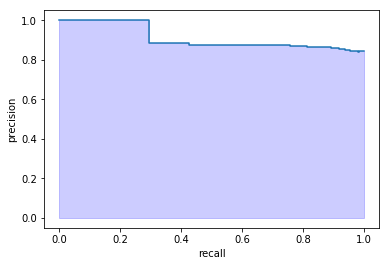

In [53]:
# plt.style.use(['dark_background'])
preds1 = clf.predict_proba(all_test[features])
precision, recall, _ = precision_recall_curve(y_test, preds1[:,0],pos_label=0)

plt.step(recall,precision)
plt.fill_between(recall, precision,step='pre', alpha=0.2,
                 color='b')
plt.xlabel('recall')
plt.ylabel('precision')

In [54]:
integrate.trapz(precision[::-1],recall[::-1])

0.8918828517315024

In [55]:

f1_score(np.array(preds),np.array(y_test))

0.08333333333333334

# SN within transients

In [66]:

all_train = diego_t_train
all_test = diego_t_test



In [74]:
all_train.head()

,,Class,ObsCount,amplitude,beyond1st,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,kurtosis,...,poly4_t2,poly4_t3,poly4_t4,skew,small_kurtosis,std,stetson_j,stetson_k,bin_class,fact_Class
ID,copy_num,,,,,,,,,,,,,,,,,,,,,
TranID1601301490384135528,4,HPM,13,0.201680,0.230769,0.128276,0.203179,0.368561,0.405794,0.774623,0.644358,...,-3.254815e-05,3.226448e-08,5.315882e-10,-0.963255,-3.927273,0.116035,1.064054,0.779512,False,0
TranID1004121040434181465,7,SN,12,0.821045,0.500000,0.785029,0.802570,0.816606,0.846517,0.913308,-2.315540,...,-1.168190e+02,-7.340511e-04,3.214634e-01,-0.008574,-4.033333,0.688105,6.689121,0.977076,True,1
TranID1109190121114107721,5,CV,81,2.040180,0.395062,0.119920,0.322553,0.482442,0.582825,0.889510,-0.876362,...,1.328852e-07,-3.116253e-11,-4.693852e-14,-0.018814,-3.115871,1.094954,3.378831,0.716476,False,0
TranID1006010090764153269,9,Blazar,225,1.872204,0.337778,0.127277,0.246815,0.351678,0.522938,0.767629,0.449904,...,6.540515e-09,-5.824525e-11,-6.860942e-14,-0.146151,-3.040601,0.617565,1.475649,0.720621,False,0
TranID1202111180194119491,6,SN,28,1.696602,0.464286,0.119691,0.307788,0.451805,0.608682,0.865437,-0.558828,...,-2.047051e-06,1.631758e-09,1.634193e-12,-0.471246,-3.364615,0.948155,2.168519,0.634728,True,1


In [67]:
all_train = all_train.sample(frac=1)
all_test = all_test.sample(frac=1)

In [68]:
features = all_train.columns[2:-2]
print(features)
y_train = np.array(all_train['fact_Class'])
y_test = np.array(all_test['fact_Class'])

Index(['amplitude', 'beyond1st', 'flux_percentile_ratio_mid20',
       'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50',
       'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80',
       'kurtosis', 'max_slope', 'median_absolute_deviation',
       'median_buffer_range_percentage', 'pair_slope_trend',
       'pair_slope_trend_last_30', 'percent_amplitude',
       'percent_difference_flux_percentile', 'poly1_t1', 'poly2_t1',
       'poly2_t2', 'poly3_t1', 'poly3_t2', 'poly3_t3', 'poly4_t1', 'poly4_t2',
       'poly4_t3', 'poly4_t4', 'skew', 'small_kurtosis', 'std', 'stetson_j',
       'stetson_k'],
      dtype='object')


In [69]:
print(len(y_train))
print(len(y_test))


35189
1070


In [70]:
clf = RandomForestClassifier(n_estimators=50,random_state=0, class_weight='balanced')
clf.fit(all_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [71]:
clf.score(all_test[features],y_test)

0.18691588785046728

In [72]:
preds = clf.predict(all_test[features])
pd.crosstab(preds, y_test, rownames=['Predicted '], colnames=['Actual '])

Actual,0,1
Predicted,,
0,138,703
1,167,62


Text(0,0.5,'precision')

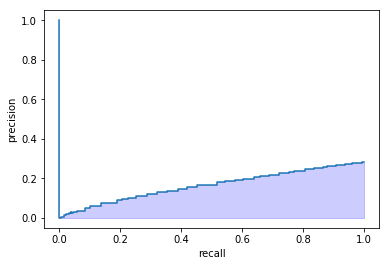

In [73]:
# plt.style.use(['dark_background'])
preds1 = clf.predict_proba(all_test[features])
precision, recall, _ = precision_recall_curve(y_test, preds1[:,0],pos_label=0)

plt.step(recall,precision)
plt.fill_between(recall, precision,step='pre', alpha=0.2,
                 color='b')
plt.xlabel('recall')
plt.ylabel('precision')

In [64]:
integrate.trapz(precision[::-1],recall[::-1])

0.16785557772464102

In [65]:
f1_score(np.array(preds),np.array(y_test))

0.12310797174571139